Adım 1, Ödül: -1
Bölüm: 1, Kayıp: 1.8189527988433838
Adım 1, Ödül: -1
Bölüm: 2, Kayıp: 0.8284338116645813
Adım 1, Ödül: 0
Adım 2, Ödül: 0
Adım 3, Ödül: -1
Bölüm: 3, Kayıp: 0.4216899871826172
Adım 1, Ödül: -1
Bölüm: 4, Kayıp: 0.07096516340970993
Adım 1, Ödül: 0
Adım 2, Ödül: 0
Adım 3, Ödül: -1
Bölüm: 5, Kayıp: 0.04454932361841202
Adım 1, Ödül: -1
Bölüm: 6, Kayıp: 0.07801640778779984
Adım 1, Ödül: -1
Bölüm: 7, Kayıp: 0.012476864270865917
Adım 1, Ödül: 0
Adım 2, Ödül: -1
Bölüm: 8, Kayıp: 0.13688614964485168
Adım 1, Ödül: -1
Bölüm: 9, Kayıp: 0.33078330755233765
Adım 1, Ödül: -1
Bölüm: 10, Kayıp: 0.40119659900665283
Adım 1, Ödül: -1
Bölüm: 11, Kayıp: 0.23948264122009277
Adım 1, Ödül: -1
Bölüm: 12, Kayıp: 0.2469179779291153
Adım 1, Ödül: 0
Adım 2, Ödül: 1
Adım 3, Ödül: -1
Bölüm: 13, Kayıp: 1.2228249311447144
Adım 1, Ödül: 0
Adım 2, Ödül: 1
Adım 3, Ödül: -1
Bölüm: 14, Kayıp: 1.0963939428329468
Adım 1, Ödül: -1
Bölüm: 15, Kayıp: 0.012214034795761108
Adım 1, Ödül: 1
Adım 2, Ödül: -1
Bölüm: 16, 

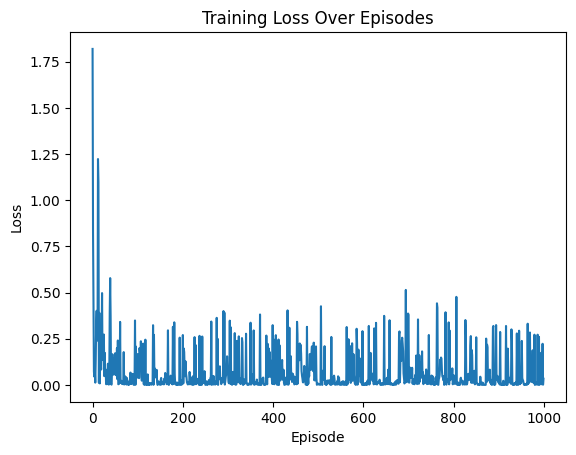

In [2]:
import numpy as np
import tensorflow as tf
import gym
from gym import spaces
import matplotlib.pyplot as plt

# Blackjack ortamını tanımlama
class BlackjackEnv(gym.Env):
    def __init__(self):
        super(BlackjackEnv, self).__init__()
        self.action_space = spaces.Discrete(2)  # 0: Stand, 1: Hit
        self.observation_space = spaces.Box(low=0, high=32, shape=(3,), dtype=np.int32)  
        self.reset()

    def reset(self):
        self.player_sum = np.random.randint(12, 22)  # Player's sum
        self.dealer_card = np.random.randint(1, 11)   # Dealer's showing card
        self.usable_ace = 1 if np.random.rand() < 0.5 else 0  # Whether player has usable Ace
        return np.array([self.player_sum, self.dealer_card, self.usable_ace], dtype=np.int32)

    def step(self, action):
        if action == 1:  # Hit
            self.player_sum += np.random.randint(1, 11)
            done = self.player_sum > 21
            reward = 1 if self.player_sum == 21 else -1 if done else 0
        else:  # Stand
            done = True
            reward = self.calculate_reward()
        return np.array([self.player_sum, self.dealer_card, self.usable_ace], dtype=np.int32), reward, done, {}

    def calculate_reward(self):
        if self.player_sum > 21:
            return -1  # Bust
        return 1  # Win

# Ortam ve modeli başlat
env = BlackjackEnv()
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Hiperparametreler
gamma = 0.99  # İskonto faktörü (future rewards için iskonto oranı)
lr_actor = 0.001  # Aktör (actor) öğrenme oranı
lr_critic = 0.001  # Eleştirmen (critic) öğrenme oranı
clip_ratio = 0.2  # PPO algoritması için clip oranı
epochs = 10  # Optimizasyon dönemlerinin (epochs) sayısı
batch_size = 64  # Optimizasyon için batch boyutu

# Aktör ve Eleştirmen Ağları
class ActorCritic(tf.keras.Model):
    def __init__(self, state_size, action_size):
        super(ActorCritic, self).__init__()
        self.dense1 = tf.keras.layers.Dense(64, activation='relu')
        self.policy_logits = tf.keras.layers.Dense(action_size)
        self.dense2 = tf.keras.layers.Dense(64, activation='relu')
        self.value = tf.keras.layers.Dense(1)

    def call(self, state):
        x = self.dense1(state)
        logits = self.policy_logits(x)
        value = self.value(self.dense2(x))
        return logits, value

# PPO kaybı (loss) fonksiyonu
def ppo_loss(old_logits, old_values, advantages, states, actions, returns):
    def compute_loss(logits, values, actions, returns):
        actions_onehot = tf.one_hot(actions, action_size, dtype=tf.float32)
        policy = tf.nn.softmax(logits)
        action_probs = tf.reduce_sum(actions_onehot * policy, axis=1)
        old_policy = tf.nn.softmax(old_logits)
        old_action_probs = tf.reduce_sum(actions_onehot * old_policy, axis=1)

        ratio = tf.exp(tf.math.log(action_probs + 1e-10) - tf.math.log(old_action_probs + 1e-10))
        clipped_ratio = tf.clip_by_value(ratio, 1 - clip_ratio, 1 + clip_ratio)
        policy_loss = -tf.reduce_mean(tf.minimum(ratio * advantages, clipped_ratio * advantages))
        value_loss = tf.reduce_mean(tf.square(values - returns))
        entropy_bonus = tf.reduce_mean(policy * tf.math.log(policy + 1e-10))
        total_loss = policy_loss + 0.5 * value_loss - 0.01 * entropy_bonus
        return total_loss

    def get_advantages(returns, values):
        advantages = returns - values
        return (advantages - tf.reduce_mean(advantages)) / (tf.math.reduce_std(advantages) + 1e-8)

    def train_step(states, actions, returns, old_logits, old_values):
        with tf.GradientTape() as tape:
            logits, values = model(states)
            loss = compute_loss(logits, values, actions, returns)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return loss

    advantages = get_advantages(returns, old_values)
    for _ in range(epochs):
        loss = train_step(states, actions, returns, old_logits, old_values)
    return loss

# Aktör-eleştirmen modelini ve optimizer'ı başlat
model = ActorCritic(state_size, action_size)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_actor)

# Ana eğitim döngüsü
max_episodes = 1000
max_steps_per_episode = 100  # Blackjack için tipik adım sayısı

# Kaybı takip etmek için bir liste
losses = []

# Eğitim döngüsü
for episode in range(max_episodes):
    states, actions, rewards, values, returns = [], [], [], [], []
    state = env.reset()

    for step in range(max_steps_per_episode):
        state = np.expand_dims(state, axis=0)  # (1, state_size) boyutuna genişlet
        logits, value = model(state)

        # Politika dağılımından aksiyon seç
        action = tf.random.categorical(logits, 1)[0, 0].numpy()

        # Ortamda aksiyon al ve çıktıları işle
        next_state, reward, done, _ = env.step(action)

        # Adımda alınan ödülü yazdır
        print(f"Adım {step+1}, Ödül: {reward}")

        states.append(state)
        actions.append(action)
        rewards.append(reward)
        values.append(value)

        state = next_state if isinstance(next_state, np.ndarray) else np.array(next_state)

        if done:
            # Geri dönüşleri hesapla ve PPO kaybı uygula
            returns_batch = []
            discounted_sum = 0
            for r in rewards[::-1]:
                discounted_sum = r + gamma * discounted_sum
                returns_batch.append(discounted_sum)
            returns_batch.reverse()

            states = tf.concat(states, axis=0)
            actions = np.array(actions, dtype=np.int32)
            values = tf.concat(values, axis=0)
            returns_batch = tf.convert_to_tensor(returns_batch)
            old_logits, _ = model(states)

            # PPO kaybını hesapla ve kaydet
            advantages = get_advantages(returns_batch, values)
            loss = compute_loss(old_logits, values, actions, returns_batch, old_logits, values, clip_ratio)
            losses.append(loss.numpy())  # Kayıp değerini listeye ekle

            # Modeli güncelleme
            with tf.GradientTape() as tape:
                logits, value = model(states)
                loss = compute_loss(logits, value, actions, returns_batch, old_logits, values, clip_ratio)
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            print(f"Bölüm: {episode + 1}, Kayıp: {loss.numpy()}")
            break

# Eğitim kaybı grafiğini çizme
plt.plot(losses)
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Training Loss Over Episodes')
plt.show()


In [ ]:
import tensorflow as tf
import numpy as np
import gym
import matplotlib.pyplot as plt

# Ortam (Environment) ayarı
env = gym.make('MountainCar-v0')
state_size = env.observation_space.shape[0]  # Durum boyutu (state dimension)
action_size = env.action_space.n  # Aksiyon boyutu (action dimension)

# Hiperparametreler
gamma = 0.99  # İskonto faktörü (future rewards için iskonto oranı)
lr_actor = 0.001  # Aktör (actor) öğrenme oranı
lr_critic = 0.001  # Eleştirmen (critic) öğrenme oranı
clip_ratio = 0.2  # PPO algoritması için clip oranı
epochs = 10  # Optimizasyon dönemlerinin (epochs) sayısı
batch_size = 64  # Optimizasyon için batch boyutu

# Aktör ve Eleştirmen Ağları
class ActorCritic(tf.keras.Model):
    def __init__(self, state_size, action_size):
        super(ActorCritic, self).__init__()
        # Ortak katmanlar
        self.dense1 = tf.keras.layers.Dense(64, activation='relu')
        # Politika çıktıları (aksiyon olasılıkları)
        self.policy_logits = tf.keras.layers.Dense(action_size)
        # Değer çıktısı (durumun değerini tahmin etmek için)
        self.dense2 = tf.keras.layers.Dense(64, activation='relu')
        self.value = tf.keras.layers.Dense(1)

    def call(self, state):
        # Ortak katmanları kullanarak ileri geçiş (forward pass)
        x = self.dense1(state)
        logits = self.policy_logits(x)  # Aksiyon olasılıkları
        value = self.value(x)  # Durumun tahmin edilen değeri
        return logits, value

# PPO algoritması kaybı (loss) fonksiyonu
def ppo_loss(old_logits, old_values, advantages, states, actions, returns):
    # PPO algoritmasında kaybı hesaplayan fonksiyon
    def compute_loss(logits, values, actions, returns):
        # Aksiyonları one-hot formatında gösteriyoruz
        actions_onehot = tf.one_hot(actions, action_size, dtype=tf.float32)
        # Politika dağılımını oluşturuyoruz
        policy = tf.nn.softmax(logits)
        # Seçilen aksiyonların olasılıklarını hesaplıyoruz
        action_probs = tf.reduce_sum(actions_onehot * policy, axis=1)
        # Eski politika olasılıklarını (old_policy) oluşturuyoruz
        old_policy = tf.nn.softmax(old_logits)
        old_action_probs = tf.reduce_sum(actions_onehot * old_policy, axis=1)

        # Politika kaybı (policy loss)
        ratio = tf.exp(tf.math.log(action_probs + 1e-10) - tf.math.log(old_action_probs + 1e-10))
        clipped_ratio = tf.clip_by_value(ratio, 1 - clip_ratio, 1 + clip_ratio)
        policy_loss = -tf.reduce_mean(tf.minimum(ratio * advantages, clipped_ratio * advantages))

        # Değer kaybı (value loss)
        value_loss = tf.reduce_mean(tf.square(values - returns))

        # Entropi bonusu (opsiyonel)
        entropy_bonus = tf.reduce_mean(policy * tf.math.log(policy + 1e-10))

        # Toplam kayıp (loss) hesaplanıyor, entropi düzenlemesi ile
        total_loss = policy_loss + 0.5 * value_loss - 0.01 * entropy_bonus
        return total_loss

    # Avantajları hesaplama fonksiyonu
    def get_advantages(returns, values):
        advantages = returns - values
        return (advantages - tf.reduce_mean(advantages)) / (tf.math.reduce_std(advantages) + 1e-8)

    # Eğitim adımı (train step)
    def train_step(states, actions, returns, old_logits, old_values):
        with tf.GradientTape() as tape:
            logits, values = model(states)
            loss = compute_loss(logits, values, actions, returns)
        # Gradyanları hesapla ve uygulama
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return loss

    # Avantajları hesapla ve optimize et
    advantages = get_advantages(returns, old_values)
    for _ in range(epochs):
        loss = train_step(states, actions, returns, old_logits, old_values)
    return loss

# Aktör-eleştirmen modelini ve optimizer'ı başlat
model = ActorCritic(state_size, action_size)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_actor)

# Ana eğitim döngüsü
max_episodes = 1000
max_steps_per_episode = 200  # MountainCar-v0 için tipik adım sayısı

# Eğitim sırasında ödülleri ve kayıpları saklamak için listeler
step_rewards = []  # Adım bazında ödül değerleri
episode_rewards = []  # Her bölümün toplam ödülü
episode_losses = []

for episode in range(max_episodes):
    # Her bölüm için durum, aksiyon, ödül, değer ve geri dönüş listeleri
    states, actions, rewards, values, returns = [], [], [], [], []
    reset_output = env.reset()
    state = reset_output[0] if isinstance(reset_output, tuple) else reset_output  # Çıktı tuple ise kontrol et

    for step in range(max_steps_per_episode):
        state = np.expand_dims(state, axis=0)  # (1, state_size) boyutuna genişlet
        logits, value = model(state)

        # Politika dağılımından aksiyon seç
        action = tf.random.categorical(logits, 1)[0, 0].numpy()

        # Ortamda aksiyon al ve çıktıları işle
        step_result = env.step(action)
        if len(step_result) == 4:
            next_state, reward, done, _ = step_result
        else:
            next_state, reward, done, truncated, _ = step_result
            done = done or truncated  # Bölüm bitti mi kontrol et

        # Özel ödül ayarlaması (MountainCar gereksinimlerine göre)
        reward = reward if not done or step == max_steps_per_episode - 1 else 100

        states.append(state)
        actions.append(action)
        rewards.append(reward)
        values.append(value)

        # Her adımın ödülünü kaydet
        step_rewards.append(reward)

        # Sonraki adım için durumu güncelle
        state = next_state if isinstance(next_state, np.ndarray) else np.array(next_state)

        if done:
            # Geri dönüşleri hesapla ve PPO kaybı uygula
            returns_batch = []
            discounted_sum = 0
            for r in rewards[::-1]:
                discounted_sum = r + gamma * discounted_sum
                returns_batch.append(discounted_sum)
            returns_batch.reverse()

            states = tf.concat(states, axis=0)
            actions = np.array(actions, dtype=np.int32)
            values = tf.concat(values, axis=0)
            returns_batch = tf.convert_to_tensor(returns_batch)
            old_logits, _ = model(states)

            # PPO kaybını hesapla
            loss = ppo_loss(old_logits, values, returns_batch - np.array(values), states, actions, returns_batch)
            print(f"Bölüm: {episode + 1}, Kayıp: {loss.numpy()}")

            # Ödül ve kaybı listeye ekle
            episode_rewards.append(sum(rewards))
            episode_losses.append(loss.numpy())

            break

# Adım bazında ödül grafiği
plt.figure(figsize=(12, 6))

# Adım bazında ödül grafiği
plt.plot(step_rewards)
plt.title('Adım Bazında Ödül Değeri (Step-wise Rewards)')
plt.xlabel('Adım (Step)')
plt.ylabel('Ödül (Reward)')
# Grafiklerin gösterilmesi
plt.show()


C:\Users\Yagmur\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'actor_critic_7', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Bölüm: 1, Kayıp: 1910.1524658203125
Bölüm: 2, Kayıp: 1904.6474609375
Bölüm: 3, Kayıp: 1898.1051025390625
Bölüm: 4, Kayıp: 1891.2579345703125
Bölüm: 5, Kayıp: 1885.038330078125
Bölüm: 6, Kayıp: 1876.333251953125
Bölüm: 7, Kayıp: 1868.962890625
Bölüm: 8, Kayıp: 1861.411865234375
Bölüm: 9, Kayıp: 1851.1265869140625
Bölüm: 10, Kayıp: 1840.65234375
Bölüm: 11, Kayıp: 1830.7294921875
Bölüm: 12, Kayıp: 1816.298095703125
Bölüm: 13, Kayıp: 1803.561279296875
Bölüm: 14, Kayıp: 1788.0234375
Bölüm: 15, Kayıp: 1774.0975341796875
Bölüm: 16, Kayıp: 1760.451416015625
Bölüm: 17, Kayıp: 1739.9493408203125
Bölüm: 18, Kayıp: 1722.5491943359375
Bölüm: 19, Kayıp: 1702.407958984375
Bölüm: 20, Kayıp: 1682.0068359375
Bölüm: 21, Kayıp: 1662.0540771484375
Bölüm: 22, Kayıp: 1643.3326416015625
Bölüm: 23, Kayıp: 1622.2425537109375
Bölüm: 24, Kayıp: 1599.47216796875
Bölüm: 25, Kayıp: 1570.6539306640625
Bölüm: 26, Kayıp: 1550.3319091796875
Bölüm: 27, Kayıp: 1528.5106201171875
Bölüm: 28, Kayıp: 1505.876220703125
Bölüm: 